# 1. Packages import

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pyodbc 
import itertools

%matplotlib inline

# 2. Data retrieval

In [4]:
datetime.now()

datetime.datetime(2019, 4, 8, 13, 12, 22, 981886)

In [5]:
# Asia index mmapping
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj


Asia_mapping=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\{0} 2007-2017.xlsx'.format('Asia'),\
                                       sheet_name='Mapping'))

In [6]:
'''Connect to post result SQL server'''
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=dsa-ln-WS015\SQLEXPRESS;DATABASE=Post_result;Trusted_Connection=yes')   
cursor = cnxn.cursor()

In [7]:
def SQL_price_date_transform(SQL_date,index=False):
    '''
    Transform the SQL price style string into dateframe string style
    The SQL price follows US style which is MM DD YYYY
    '''
    if index==False:
        timestamp=pd.Timestamp(int(SQL_date[SQL_date.find(" ",3):]),
                            int(SQL_date[:SQL_date.find(" ")]),
                            int(SQL_date[SQL_date.find(" ",1):SQL_date.find(" ",3)]))
        return timestamp.strftime("%d/%b/%Y")
    else:
        timestamp=pd.Timestamp(int(SQL_date[-4:]),int(SQL_date[3:5]),int(SQL_date[:2]))
        return timestamp

In [8]:
def SQL_fundamental_date_transform(SQL_date):
    '''
    Transform the SQL fundamental style string into dateframe string style
    '''
    timestamp=pd.Timestamp(int(SQL_date[:4]),
                        int(SQL_date[5:7]),
                        int(SQL_date[8:]))
    return timestamp

In [9]:
def SQL_price(region,start,end):
    '''
    Grab the pricing data from SQL database
    region= US, Europe,Asia,or Canada
    start,end are in year
    key is the reference to search
    return the target price dataframe with timestamp on the column
    '''
    mylist=[]
    for year in range(start,end+1):
        sql="select * from {0}_price_{1}".format(region,year)
        data=pd.read_sql(sql,cnxn).set_index("Ticker")
        adj_data=data.loc[[x for x in data.index if len(x)>0]].replace('#N/A N/A','')
        mylist.append(adj_data)

    price=pd.concat(mylist,axis=1)
    price=price.apply(lambda x:pd.to_numeric(x),axis=1)
    
    sql_index="select * from {0}_price_index".format(region)
    data_index=pd.read_sql(sql_index,cnxn).set_index("Ticker").T
    data_index=data_index.replace('#N/A N/A','')
    price_index=data_index.apply(lambda x:pd.to_numeric(x),axis=1)
    
    price.columns=[SQL_price_date_transform(i) for i in price.columns]
    '''
    Need to sort the columns for index price, and then transform to date string
    '''
    price_index.columns=[SQL_price_date_transform(i,index=True) for i in price_index.columns]
    price_index=price_index.reindex(sorted(price_index.columns), axis=1)
    price_index.columns=[i.strftime("%d/%b/%Y") for i  in price_index.columns]
    
    abs_return=price.diff(1,axis=1)/price.shift(1,axis=1)
    abs_return_index=price_index.diff(1,axis=1)/price_index.shift(1,axis=1)
    return price,abs_return,price_index,abs_return_index

In [10]:
def SQL_EPS(region,start,end):
    '''
    Grab the pricing data from SQL database
    region= US, Europe,Asia,or Canada
    start,end are in year
    key is the reference to search
    return the target EPS dataframe with timestamp on the column
    '''
    mylist=[]
    for year in range(start,end+1):
        sql="select * from {0}_EPS_{1}".format(region,year)
        data=pd.read_sql(sql,cnxn).set_index("Ticker")
        adj_data=data.loc[[x for x in data.index if len(x)>0]].replace('#N/A N/A','')
        mylist.append(adj_data)

    EPS=pd.concat(mylist,axis=1)
    EPS=EPS.apply(lambda x:pd.to_numeric(x),axis=1)
    
    EPS.columns=[SQL_price_date_transform(i) for i in EPS.columns]
    return EPS

In [11]:
def SQL_fundamentals(region,abs_return):
    '''
    Grab the fundamental data from SQL database
    region= US, Europe,Asia,or Canada
    return the post result fundamental dataframe
    '''
    sql="select * from {0}".format(region)
    data=pd.read_sql(sql,cnxn).set_index("Ticker").drop_duplicates().replace('#N/A Invalid Security','')
    
    data=data[data.index!='']
    
    data["Date"]=[SQL_fundamental_date_transform(i) for i in data["Date"]]
    data["ticker_copy"]=data.index
    data=data.sort_values(by=["ticker_copy","Date"])
    data["next_date"]=data["Date"].shift(-1)
    data["ticker_copy"]=data["ticker_copy"].shift(-1)
    data["Date"]=data["Date"].apply(lambda x: x.strftime("%d/%b/%Y") if x!='' else np.nan)
    data["Next"]=data.apply(lambda x: x["next_date"].strftime("%d/%b/%Y") if x.name==x["ticker_copy"] else np.nan,axis=1)

    del data["ticker_copy"]
    del data["next_date"]
     
    data.index=pd.MultiIndex.from_tuples(data.apply(lambda x:(x.name,x["Date"],x["Next"]),axis=1))
    
    for s in ["Revision","Revision vol","Market cap","Volume"]:
        try:
            data[s]=pd.to_numeric(data[s])
        except KeyError:
            pass
            
    
    '''
    take out data with zero or none revision
    '''
    data=data[(data["Revision"]>0)|(data["Revision"]<0)]
    
    if 'Revision vol' in data.columns:
        data=data[(data["Revision vol"]>0)|(data["Revision vol"]<0)]
        data["Revision_norm"]=data.apply(lambda x: x["Revision"]/x["Revision vol"] if x["Revision vol"]!=0 else None,axis=1)
    
    
    data["30d_vol"]=data.apply(lambda x: abs_return.loc[x.name[0],:x.name[1]][-31:-1].std() if x.name[1] in abs_return.columns\
                               else None,axis=1)
    
    
    return data

In [16]:
US_price,abs_return_US,US_index_price,abs_return_index_US=SQL_price('US',2006,2019)

In [18]:
US=SQL_fundamentals("US",abs_return_US)

In [82]:
Asia_price,abs_return_Asia,Asia_index_price,abs_return_index_Asia=SQL_price('Asia',2007,2019)

In [88]:
Asia=SQL_fundamentals("Asia",abs_return_Asia)

In [56]:
Europe_price,abs_return_Europe,Europe_index_price,abs_return_index_Europe=SQL_price('Europe',2006,2019)

In [58]:
Europe=SQL_fundamentals("Europe",abs_return_Europe)

# 3. Utility functions

In [20]:
def EAR_calc(ticker,date,return_df,EAR_period,vol_lookback):
    '''
    Calculate EAR from ticker and reference date
    '''
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    return_series=return_df.loc[ticker].dropna()
    date_series=return_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        post_series=return_series.iloc[day0:]
        pre_series=return_series.iloc[:day0]
        vol= return_series.iloc[day0-min(len(pre_series),vol_lookback+1):day0].std()
        ret=(return_series.iloc[day0:day0+EAR_period]+1).prod()-1
        nmove=ret/vol
        return nmove
    else:
        return None

In [21]:
def signal_vol(signal_column,return_df,vol_lookback):
    '''
    Calculate simple vol from signal tuple
    '''
    signal_series=return_df.loc[signal_column.name[0]]
    location=signal_series.index.tolist().index(signal_column.name[1])
    vol_range=min(vol_lookback,len(signal_series[:location]))
    signal_vol=signal_series[location-vol_range-1:location].std()
    return signal_vol

In [22]:
def slice_universe(signal_df,start_datetime,end_datetime):
    '''
    Slice the signal_df, both the index and entry date have to be 
    '''
    
    entry=signal_df.apply(lambda x:datetime.strptime(x.name[1],"%d/%b/%Y"),axis=0)
    period_evaluate=(entry>=start_datetime)&(entry<=end_datetime)
    adj_signal_df=signal_df.loc[:,period_evaluate]
    adj_signal_df=adj_signal_df.loc[start_datetime:end_datetime]
    
    zero_index=pd.date_range(start_datetime,end_datetime,freq='B').to_frame()
    adj_signal_df=pd.concat([adj_signal_df,zero_index],axis=1).iloc[:,:-1]
    return adj_signal_df
    

In [23]:
def signal_filter_stop(signal_df,stop_level,return_df,vol_lookback):
    '''
    Input - signal_df
    Get the updated signal df after the stop loss
    '''
    
    vol_row=signal_df.apply(lambda column:signal_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [24]:
def sizing(signal_df,reference,gross,fundamental_df,return_df,risk_parity,liquidity,capital):
    '''
    Use historical signal_df range to calculate the size row for the current signal_df range
    Idea is to use historical as a benchmark for future sizing
    '''
    number=reference.count(axis=1).mean()
    avg_size=gross/100/number
    vol_reference=reference.apply(lambda column:signal_vol(column,return_df,30),axis=0).mean()
    vol_row=signal_df.apply(lambda column:signal_vol(column,return_df,30),axis=0)
    
    fundamental_df=fundamental_df.sort_index()
    if risk_parity is True:
        size_row=signal_df.apply(lambda x: min(avg_size/(vol_row[x.name]/vol_reference),\
                                               fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]*\
                                               liquidity/capital),axis=0)
    else:
        size_row=signal_df.apply(lambda x: min(avg_size, fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]\
                                               *liquidity/capital),axis=0)
    return size_row

In [25]:
def trading_analytics_date(portfolio_cache):
    '''
    Key portfolio metrics from portfolio cache
    Feed into plot function
    '''
    
    ind_return=portfolio_cache[3]
    signal_count=len(ind_return)
    account_curve=portfolio_cache[1]
    
    if signal_count==0:
        return None,None,None,None,None,None,None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=(account_price.iloc[-1]**(1/len(account_price)))**260-1
        ann_sharpe=ann_ret/ann_vol
        
        max_dd=-((1+account_curve)/(1+account_curve).cummax(axis=0)-1).expanding().min().min()
        
        #low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        #high_date=account_curve[:low_date].idxmax()
        #max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [26]:
def trading_analytics_simp(account_curve):
    '''
    Key portfolio metrics from portfolio account curve
    Only sharpe and drawdown
    '''


    account_price=account_curve+1
    ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
    ann_ret=(account_price.iloc[-1]**(1/len(account_price)))**260
    ann_sharpe=ann_ret/ann_vol

    max_dd=-((1+account_curve)/(1+account_curve).cummax(axis=0)-1).expanding().min().min()

    #low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
    #high_date=account_curve[:low_date].idxmax()
    #max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])

    return ann_sharpe,max_dd

In [27]:
def plot_signal(title,figsize,portfolio_cache):

    account_curve=portfolio_cache[1]
    avg_size=np.abs(portfolio_cache[2]).mean(axis=0).mean()
    ind_return=portfolio_cache[3]
    gross=portfolio_cache[4]
    turnover=portfolio_cache[5]

    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.1))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])

    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='gross',color='silver')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])

    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(portfolio_cache)

    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Exposure')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2],loc=2)
    ax1.axhline(y=0,color='k')

    plt.show()        

# 4. Signal class 

In [28]:
class signal(object):
    '''
    Signal class is built to initialize the signal_df and account curve from base parameters 
    '''
    def __init__(self,fundamental_df,price_df,EAR_period,long_criteria,short_criteria,holding,start,end):
        '''
        Define the key free parameters of the signal
        Criteria:(EAR,revision,revision_norm,size)
        '''
        self.fundamental_df=fundamental_df
        self.price_df=price_df
        self.abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
        self.EAR_period=EAR_period
        self.long_criteria=long_criteria
        self.short_criteria=short_criteria
        self.holding=holding
        self.start=start
        self.end=end
        
    def signal_base(self):
        '''
        Filter the signal criteria like EAR and revision, get the target signal list
        From the fundamental information
        For both long and short side
        '''
        
        long_base=self.fundamental_df.copy()
        short_base=self.fundamental_df.copy()
        
        if self.long_criteria is None:
            long_base=None
        else:
            
            if self.long_criteria[1] is None:
                pass
            else:
                long_base=long_base[(long_base["Revision"]>self.long_criteria[1][0])\
                                                    &(long_base["Revision"]<self.long_criteria[1][1])]

            if self.long_criteria[2] is None:
                pass
            else:
                long_base=long_base[(long_base["Revision_norm"]>self.long_criteria[2][0])\
                                                    &(long_base["Revision_norm"]<self.long_criteria[2][1])]
                
            if self.long_criteria[3] is None:
                pass
            else:
                long_base=long_base[(long_base["Market cap"]>self.long_criteria[3][0])&\
                                        (long_base["Market cap"]<self.long_criteria[3][1])]
            
            if self.long_criteria[0] is None:
                pass
            else:
            
                long_base["EAR"]=long_base.apply(lambda x:EAR_calc(x.name[0],x.name[1],self.abs_return,self.EAR_period,30)\
                                             if x.name[0] in self.abs_return.index else None,axis=1)

                long_base=long_base[(long_base["EAR"]>self.long_criteria[0][0])&(long_base["EAR"]<self.long_criteria[0][1])]
                
                
        if self.short_criteria is None:
            short_base=None
        else:
            
            if self.short_criteria[1] is None:
                pass
            else:
                short_base=short_base[(short_base["Revision"]>self.short_criteria[1][0])\
                                                    &(short_base["Revision"]<self.short_criteria[1][1])]

            if self.short_criteria[2] is None:
                pass
            else:
                short_base=short_base[(short_base["Revision_norm"]>self.short_criteria[2][0])\
                                                    &(short_base["Revision_norm"]<self.short_criteria[2][1])]
                
            if self.short_criteria[3] is None:
                pass
            else:
                short_base=short_base[(short_base["Market cap"]>self.short_criteria[3][0])&\
                                        (short_base["Market cap"]<self.short_criteria[3][1])]
            
            if self.short_criteria[0] is None:
                pass
            else:
            
                short_base["EAR"]=short_base.apply(lambda x:EAR_calc(x.name[0],x.name[1],self.abs_return,self.EAR_period,30)\
                                             if x.name[0] in self.abs_return.index else None,axis=1)

                short_base=short_base[(short_base["EAR"]>self.short_criteria[0][0])&\
                                      (short_base["EAR"]<self.short_criteria[0][1])]
                
        return long_base,short_base
    
    def signal_df_date(self):#if we hold them through next earning
        '''
        Obtain the signal_df function over the whole time period from the target signal list
        '''
        long_base,short_base=signal.signal_base(self)
        
        if long_base is None:
            long_df=None
            self.long_df=None
        
        else:
            long_df=pd.DataFrame(index=self.price_df.columns)

            for s in long_base.index:
                return_series=self.abs_return.loc[s[0]]
                if s[1] in return_series.index:
                    if not np.isnan(return_series.loc[s[1]]): 
                        day0=return_series.index.tolist().index(s[1])
                        if type(s[2])==float:##basically np.nan has type float
                            period=self.holding
                        else: ##assume that we are not holding through numbers
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),\
                                                                    datetime.strptime(s[2],"%d/%b/%Y"))-self.EAR_period)\
                            #EAR period as entry
                        target_series=return_series.iloc[day0+self.EAR_period-1:day0+min(period+self.EAR_period, \
                                                                                       len(return_series[day0:]))].dropna()
                        if len(target_series)==0:
                            pass
                        else:
                            target_series.iloc[0]=0.0
                            long_df[s]=target_series                        

            long_df=long_df.reindex(datetime.strptime(i,"%d/%b/%Y") for i in long_df.index)

            if self.start is not None:
                long_df=slice_universe(long_df,self.start,self.end)
            else:
                pass
            
            long_df=long_df.dropna(how="all",axis=1)
            #long_df.columns=pd.MultiIndex.from_tuples(pd.Series(list(long_df.columns)))
            self.long_df=long_df
            
            
        
        if short_base is None:
            short_df=None
            self.short_df=None
        
        else:
            short_df=pd.DataFrame(index=self.price_df.columns)

            for s in short_base.index:
                return_series=self.abs_return.loc[s[0]]
                if s[1] in return_series.index:
                    if not np.isnan(return_series.loc[s[1]]): 
                        day0=return_series.index.tolist().index(s[1])
                        if type(s[2])==float:##basically np.nan has type float
                            period=self.holding
                        else: ##assume that we are not holding through numbers
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),\
                                                                    datetime.strptime(s[2],"%d/%b/%Y"))-self.EAR_period)\
                            #EAR period as entry
                        target_series=return_series.iloc[day0+self.EAR_period-1:day0+min(period+self.EAR_period, \
                                                                                       len(return_series[day0:]))].dropna()
                        if len(target_series)==0:
                            pass
                        else:
                            target_series.iloc[0]=0.0
                            short_df[s]=target_series                        

            short_df=short_df.reindex(datetime.strptime(i,"%d/%b/%Y") for i in short_df.index)

            if self.start is not None:
                short_df=slice_universe(short_df,self.start,self.end)
            else:
                pass  
            
            short_df=short_df.dropna(how="all",axis=1)
            #short_df.columns=pd.MultiIndex.from_tuples(pd.Series(list(short_df.columns)))
            self.short_df=short_df
        
        return long_df,short_df

    def signal_account(self,stop,gross,index_df,net_level,risk_parity,liquidity,capital):
        '''
        Build the account curve with signal_df
        Assume quarterly rebalancing that's why the period list has quarter as the key
        Take extra care when building the account curve, the logic is: work out the size_df, then shift by 1 and * signal_df
        Stop=(long_stop,short_stop)
        index_df has to be a dataframe with a name
        '''
        
        try:
            long_df=self.long_df.copy()
            short_df=self.short_df.copy()
            
        except:
            long_df,short_df=self.signal_df_date()
                   
        '''
        Assign values for later use
        '''
        
        self.capital=capital
        
        self.index_df=index_df
        self.index_df.index=[datetime.strptime(i,"%d/%b/%Y") for i in self.index_df.index]
       
        
        '''
        Define rebalance period first
        '''
        if long_df is None:
            period=short_df.apply(lambda x:str(x.name.year)+" "+str(x.name.quarter),axis=1)
            period_list=list(set(period))
            period_list.sort()    
            
        else:
            period=long_df.apply(lambda x:str(x.name.year)+" "+str(x.name.quarter),axis=1)
            period_list=list(set(period))
            period_list.sort()    
                
        '''
        Separate out long and short
        '''
        if long_df is None:
            long_cache=(None,None,None,None)
        else:
            if stop is None:
                pass
            else:
                long_df=signal_filter_stop(long_df,stop[0],self.abs_return,30)   

            long_sub_signal={}
            long_sub_size_row={}
            long_sub_size_df={}
            long_sub_pnl={}
        
            for s in period_list:
                
                long_sub_signal[s]=long_df[period==s].dropna(how='all',axis=1)
                
                if long_sub_signal[s].shape[1]==0:
                    long_sub_size_df[s]=long_sub_signal[s]
                    long_sub_pnl[s]=long_sub_signal[s]
                    
                else:
                    if period_list.index(s)<4:##use last quarter's sizing as reference
                        long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[s],gross[0],self.fundamental_df,\
                                                       self.abs_return,risk_parity,liquidity,capital)
                    else:
                        try:
                            long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[period_list[period_list.index(s)-1]],\
                                                       gross[0],self.fundamental_df,self.abs_return,\
                                                        risk_parity,liquidity,capital)
                        except:
                            long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[s],\
                                                       gross[0],self.fundamental_df,self.abs_return,\
                                                        risk_parity,liquidity,capital) 

                    long_sub_size_df[s]=(1+long_sub_signal[s]).cumprod()*long_sub_size_row[s]
                    long_sub_pnl[s]=(long_sub_size_df[s].shift(1))*long_sub_signal[s] 
                    # need to shift by 1 as the size is end of the day
        
            long_daily_pnl=pd.concat(list(long_sub_pnl.values()),axis=0)
            long_acct_curve=long_daily_pnl.cumsum().ffill().sum(axis=1)
            long_size_df=pd.concat(list(long_sub_size_df.values()),axis=0)
            long_ind_return=long_daily_pnl.cumsum().ffill().iloc[-1].dropna()
            long_cache=(long_daily_pnl,long_acct_curve,long_size_df,long_ind_return)

            
        if short_df is None:
            short_cache=(None,None,None,None)
        else:
            if stop is None:
                pass
            else:
                short_df=-signal_filter_stop(-short_df,stop[1],self.abs_return,30)   

            short_sub_signal={}
            short_sub_size_row={}
            short_sub_size_df={}
            short_sub_pnl={}
        
            for s in period_list:
                short_sub_signal[s]=short_df[period==s].dropna(how='all',axis=1)

                if short_sub_signal[s].shape[1]==0:
                    short_sub_size_df[s]=short_sub_signal[s]
                    short_sub_pnl[s]=short_sub_signal[s]
                    
                else:
                    
                    if period_list.index(s)<4:##use last quarter's sizing as reference
                        short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal[s],gross[1],self.fundamental_df,\
                                                       self.abs_return,risk_parity,liquidity,capital)
                    else:
                        try:
                            short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal\
                                                          [period_list[period_list.index(s)-1]],\
                                                           gross[1],self.fundamental_df,self.abs_return,risk_parity,liquidity,\
                                                          capital)
                        except:
                            short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal[s],\
                                                           gross[1],self.fundamental_df,self.abs_return,risk_parity,liquidity,\
                                                          capital)

                    short_sub_size_df[s]=(1+short_sub_signal[s]).cumprod()*short_sub_size_row[s]
                    short_sub_pnl[s]=(short_sub_size_df[s].shift(1))*short_sub_signal[s] 
                # need to shift by 1 as the size is end of the day
        
            short_daily_pnl=pd.concat(list(short_sub_pnl.values()),axis=0)
            short_acct_curve=short_daily_pnl.cumsum().ffill().sum(axis=1)
            short_size_df=pd.concat(list(short_sub_size_df.values()),axis=0)
            short_ind_return=short_daily_pnl.cumsum().ffill().iloc[-1].dropna()
            
            short_cache=(short_daily_pnl,short_acct_curve,short_size_df,short_ind_return)
    
        '''Put alpha positions together to form the alpha part'''
        alpha_df=pd.concat([long_df,short_df],axis=1)
        self.alpha_df=alpha_df
        
        alpha_daily_pnl=pd.concat([long_cache[0],short_cache[0]],axis=1)
        alpha_acct_curve=alpha_daily_pnl.cumsum().ffill().sum(axis=1)
        alpha_size_df=pd.concat([long_cache[2],short_cache[2]],axis=1)
        alpha_ind_return=pd.concat([long_cache[3],short_cache[3]],axis=0)
        
        alpha_cache=(alpha_daily_pnl,alpha_acct_curve,alpha_size_df,alpha_ind_return)
        
        
        if self.index_df is not None:
            if self.index_df.shape[1]==1:
                index_df=self.index_df.copy().loc[alpha_df.index] 
                index_size_df=(net_level-alpha_size_df.sum(axis=1)).to_frame(index_df.columns[0])
                index_daily_pnl=index_size_df.shift(1)*index_df
                index_acct_curve=index_daily_pnl.cumsum()
                index_ind_return=index_acct_curve.iloc[-1]
                index_cache=(index_daily_pnl,index_acct_curve,index_size_df,index_ind_return)
            else:
                index_df=self.index_df.copy().loc[alpha_df.index] 
                alpha_temp=alpha_cache[2].copy().T
                alpha_temp["index"]=alpha_temp.apply(lambda x:Asia_mapping.loc[x.name[0][-2:]].iloc[0],axis=1)
                index_size_df=net_level-alpha_temp.groupby("index").apply(sum).T.iloc[:-1]
                index_daily_pnl=index_size_df.shift(1)*index_df
                index_acct_curve=index_daily_pnl.cumsum()
                index_ind_return=index_acct_curve.iloc[-1]
                index_cache=(index_daily_pnl,index_acct_curve,index_size_df,index_ind_return)
        else:
            index_cache=(None,None,None,None)
            
        '''Finally put everything together'''    
        portfolio_df=pd.concat([alpha_df,index_df],axis=1)
            
        portfolio_size_df=pd.concat([alpha_cache[2],index_cache[2]],axis=1)
  
        portfolio_daily_pnl=pd.concat([alpha_cache[0],index_cache[0]],axis=1)

        portfolio_acct_curve=portfolio_daily_pnl.cumsum().ffill().sum(axis=1)
        portfolio_ind_return=alpha_cache[3].copy()
        
        portfolio_gross=np.abs(portfolio_size_df).sum(axis=1)
        portfolio_turnover=(np.abs(alpha_size_df.fillna(0.0).diff(1)).sum().sum())/(portfolio_size_df.shape[0]/260)
        
        portfolio_cache=(portfolio_daily_pnl,portfolio_acct_curve,portfolio_size_df,portfolio_ind_return,portfolio_gross,\
                         portfolio_turnover,portfolio_df)
        
        self.portfolio_account=portfolio_cache #save for later use
        
        
        return long_cache,short_cache,alpha_cache,portfolio_cache
    
    def plot_account(self,title,figsize=[6,4],portfolio=None):
        '''
        Plot the account curve
        '''
        if portfolio is None:
            try:
                portfolio_cache=self.portfolio_account

            except AttributeError:
                print("Execute the signal_account first!")  
                return None
        else:
            portfolio_cache=portfolio
        
        plot_signal(title,figsize,portfolio_cache)

In [29]:
def combine_signal(portfolio_list,capital_list):
    
    
    daily_pnl_list=[]
    signal_df_list=[]
    portfolio_size_list=[]
    for i in range(len(portfolio_list)):

        daily_pnl_list.append(portfolio_list[i][0]*capital_list[i]/np.sum(capital_list))
        signal_df_list.append(portfolio_list[i][-1]*capital_list[i]/np.sum(capital_list))
        portfolio_size_list.append(portfolio_list[i][2]*capital_list[i]/np.sum(capital_list))
    
    daily_pnl=pd.concat(daily_pnl_list,axis=1)
    signal_df=pd.concat(signal_df_list,axis=1)
    size_df=pd.concat(portfolio_size_list,axis=1)
    
    account_curve=daily_pnl.cumsum().ffill().sum(axis=1)
    ind_return=daily_pnl.cumsum().ffill().iloc[-1]

    gross=np.abs(size_df).sum(axis=1)
    turnover=(np.abs(size_df.fillna(0.0).diff(1)).sum().sum())/(size_df.shape[0]/260)
    
    portfolio_cache=(daily_pnl,account_curve,size_df,ind_return,gross,turnover,signal_df)
    return portfolio_cache


In [30]:
def sharpe_by_year(account_curve,year_list):
    result_dict={}
    for i in year_list:
        sub_curve=account_curve.iloc[(account_curve.index>=pd.Timestamp(i,1,1))&(account_curve.index<=pd.Timestamp(i,12,31))]
        result_dict[i]=trading_analytics_simp(sub_curve)[0]
    return result_dict

In [31]:
def dd_by_year(account_curve,year_list):
    result_dict={}
    for i in year_list:
        sub_curve=account_curve.iloc[(account_curve.index>=pd.Timestamp(i,1,1))&(account_curve.index<=pd.Timestamp(i,12,31))]
        result_dict[i]=trading_analytics_simp(sub_curve)[1]
    return result_dict

# 5 - Fitting choice

In [32]:
def fitting_df(long,EAR_list,revision_list,fundamental_df,price_df,EAR_period,holding,start,end,stop,gross,index_df,
               net_level,risk_parity,liquidity,capital,exclusive):
    '''
    Create a dataframe of sharpe and drawdown for different fitting variations
    EAR/revision list includes the upper bound
    '''
    year_list=range(start.year,end.year+1)
    EAR_list.sort()
    revision_list.sort()
    
    criteria_list_short=list(itertools.product(*[EAR_list[1:],revision_list[1:]]))
    criteria_list_long=list(itertools.product(*[EAR_list[:-1],revision_list[:-1]]))
    
    sharpe_dict={}
    dd_dict={}
    if exclusive:
        if long:
            for s in criteria_list_long:
                signal_class=signal(fundamental_df=fundamental_df,
                                   price_df=price_df,
                                   EAR_period=EAR_period,
                                   long_criteria=((s[0],EAR_list[EAR_list.index(s[0])+1]),\
                                                  (s[1],revision_list[revision_list.index(s[1])+1]),None,None),
                                   short_criteria=None,
                                   holding=holding,
                                   start=start,
                                   end=end)
                
                portfolio=signal_class.signal_account(stop=stop,
                                                      gross=gross,
                                                      index_df=index_df.copy(),
                                                      net_level=net_level,
                                                      risk_parity=risk_parity,
                                                      liquidity=liquidity,
                                                      capital=capital)

                sharpe_dict[s]=sharpe_by_year(portfolio[-1][1],year_list)
                dd_dict[s]=dd_by_year(portfolio[-1][1],year_list)
                
        else:
            for s in criteria_list_short:
                signal_class=signal(fundamental_df=fundamental_df,
                                   price_df=price_df,
                                   EAR_period=EAR_period,
                                   long_criteria=None,
                                   short_criteria=((EAR_list[EAR_list.index(s[0])-1],s[0]),\
                                                   (revision_list[revision_list.index(s[1])-1],s[1]),None,(5000,10000000)),
                                   holding=holding,
                                   start=start,
                                   end=end)

                portfolio=signal_class.signal_account(stop=stop,
                                                      gross=gross,
                                                      index_df=index_df.copy(),
                                                      net_level=net_level,
                                                      risk_parity=risk_parity,
                                                      liquidity=liquidity,
                                                      capital=capital)

                sharpe_dict[s]=sharpe_by_year(portfolio[-1][1],year_list)
                dd_dict[s]=dd_by_year(portfolio[-1][1],year_list)
    
    else:
        if long:
            for i in criteria_list_long:
                signal_class=signal(fundamental_df=fundamental_df,
                                   price_df=price_df,
                                   EAR_period=EAR_period,
                                   long_criteria=((i[0],10),(i[1],10),None,None),
                                   short_criteria=None,
                                   holding=holding,
                                   start=start,
                                   end=end)

                portfolio=signal_class.signal_account(stop=stop,
                                                      gross=gross,
                                                      index_df=index_df.copy(),
                                                      net_level=net_level,
                                                      risk_parity=risk_parity,
                                                      liquidity=liquidity,
                                                      capital=capital)

                sharpe_dict[i]=sharpe_by_year(portfolio[-1][1],year_list)
                dd_dict[i]=dd_by_year(portfolio[-1][1],year_list)
                
        else:
            for i in criteria_list_short:
                signal_class=signal(fundamental_df=fundamental_df,
                                   price_df=price_df,
                                   EAR_period=EAR_period,
                                   long_criteria=None,
                                   short_criteria=((-10,i[0]),(-10,i[1]),None,(5000,10000000)),
                                   holding=holding,
                                   start=start,
                                   end=end)
                
                portfolio=signal_class.signal_account(stop=stop,
                                                      gross=gross,
                                                      index_df=index_df.copy(),
                                                      net_level=net_level,
                                                      risk_parity=risk_parity,
                                                      liquidity=liquidity,
                                                      capital=capital)

                sharpe_dict[i]=sharpe_by_year(portfolio[-1][1],year_list)
                dd_dict[i]=dd_by_year(portfolio[-1][1],year_list)

    sharpe_df=pd.DataFrame(sharpe_dict)
    dd_df=pd.DataFrame(dd_dict)
        
    return sharpe_df,dd_df
        

In [94]:
Europe_long_sharpe,Europe_long_dd=fitting_df(True,[1,2,3,10],[0.02,0.03,0.04,0.05,10],Europe,Europe_price,2,30,\
                                             pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,None),(30,None)\
                                             ,abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),0,True,0.2,50)

In [74]:
Europe_short_sharpe,Europe_short_dd=fitting_df(False,[-1,-2,-3,-4],[-0.02,-0.03,-0.04,-0.05,-0.06],Europe,Europe_price,2,30,\
                                             pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,8),(30,30)\
                                             ,abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),0,True,0.2,50)

In [75]:
Europe_short_sharpe.to_csv("Europe_short_sharpe.csv")

In [76]:
Europe_short_dd.to_csv("Europe_short_dd.csv")

In [77]:
US_long_sharpe,US_long_dd=fitting_df(True,[1,2,3,4],[0.02,0.03,0.04,0.05,0.06,0.07],\
                                     US,US_price,2,30,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,None),(30,None)\
                                             ,(0.5*abs_return_index_US.loc["SPX Index"]+0.5*abs_return_index_US.loc["RTY Index"])\
                                     .to_frame('US'),0,True,0.2,50)

In [360]:
adj_US_long_sharpe,adj_US_long_dd=fitting_df(True,[1,2,3,4],[0.02,0.03,0.04,0.05,0.06,0.07],\
                                     adj_US,US_price,2,30,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,None),(30,None)\
                                             ,(0.5*abs_return_index_US.loc["SPX Index"]+0.5*abs_return_index_US.loc["RTY Index"])\
                                     .to_frame('US'),0,True,0.2,50,False)

In [35]:
US_short_sharpe,US_short_dd=fitting_df(False,[-1,-2,-3,-4],[-0.02,-0.03,-0.04,-0.05,-0.06,-0.07],\
                                     US,US_price,2,30,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,8),(30,30)\
                                             ,(0.5*abs_return_index_US.loc["SPX Index"]+0.5*abs_return_index_US.loc["RTY Index"])\
                                     .to_frame('US'),0,True,0.2,50)

In [365]:
adj_US_short_sharpe,adj_US_short_dd=fitting_df(False,[-1,-2,-3],[-0.02,-0.03,-0.04,-0.05],\
                                     adj_US,US_price,2,30,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,8),(30,30)\
                                             ,(0.5*abs_return_index_US.loc["SPX Index"]+0.5*abs_return_index_US.loc["RTY Index"])\
                                     .to_frame('US'),0,True,0.2,50,False)

In [37]:
US_short_sharpe.to_csv("US_short_sharpe.csv")

In [38]:
US_short_dd.to_csv("US_short_dd.csv")

In [41]:
Asia_long_sharpe,Asia_long_dd=fitting_df(True,[1,2,3,4],[0.02,0.03,0.04,0.05,0.06,0.07],\
                                     Asia,Asia_price,2,20,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,None),(30,None)\
                                             ,abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T\
                                     ,0,True,0.2,50)

In [42]:
Asia_long_sharpe

1                                                           2  \
          0.02      0.03      0.04      0.05      0.06      0.07      0.02   
2007  2.585954  3.006827  3.139588  2.756801  3.807410  3.741431  2.511972   
2008  2.383659  1.861545  1.895812  2.168893  1.631356  1.540143  1.657009   
2009  1.458193  1.334734  1.477764  1.683250  1.601090  1.644103  0.018058   
2010  2.415745  2.479414  2.452798  2.437525  2.810077  2.897900  1.985948   
2011  3.261640  2.996324  2.895463  2.445924  2.617451  2.547728  3.242670   
2012  0.874880  1.388446  1.271344  1.386374  1.459201  0.843698  0.726600   
2013  3.339498  3.965355  3.367329  3.402558  3.026223  2.544389  2.605617   
2014  5.058807  4.985414  4.354542  3.758621  3.233744  3.237803  4.889390   
2015  3.345280  3.649703  3.554840  3.041516  2.476572  3.083114  3.053631   
2016  1.269745  1.749041  1.641581  1.385822  1.696787  1.699916  0.977405   
2017  4.357418  3.871980  3.889260  3.631166  3.536687  3.828939  4.114771   
2018  3.991288  4.141401  4.011955  3.901321  3.903273  4.011087  3.324495   

                                      ...            3                      \
          0.03      0.04      0.05    ...         0.04      0.05      0.06   
2007  2.878356  3.090850  2.651545    ...     1.397759  1.104338  1.747368   
2008  1.089443  1.118189  1.570182    ...     1.321232  1.421778  0.288703   
2009 -0.245812 -0.259295 -0.210340    ...     0.345619  0.388443  0.449322   
2010  2.206493  2.149520  2.088243    ...     1.579516  1.456781  1.693129   
2011  2.850490  2.883534  2.605163    ...     1.812454  1.852642  2.068205   
2012  1.353511  0.914728  0.612126    ...    -0.033529  0.110761  0.430457   
2013  3.110553  2.969218  3.111885    ...     2.105366  1.966708  1.739549   
2014  4.751273  4.370896  3.875642    ...     3.185579  3.015155  2.871920   
2015  3.259345  3.046324  2.444882    ...     2.413945  1.881111  1.523762   
2016  1.738132  1.698559  1.551403    ...     1.973405  1.707071  2.385125   
2017  3.676775  4.020277  3.738632    ...     3.675808  3.346229  3.018876   
2018  3.362245  3.436289  3.349290    ...     3.071797  3.022828  2.863021   

                       4                                                    
          0.07      0.02      0.03      0.04      0.05      0.06      0.07  
2007  2.277659  0.308225  0.597137  0.566642  0.482150  0.939385  1.322255  
2008  0.890612  1.937440  1.243958  1.485321  1.573891  0.390445  1.194959  
2009  0.482238  0.376766  0.302098  0.387860  0.285928  0.402017  0.579476  
2010  2.224956  2.650431  2.350311  2.198587  1.998698  1.979342  1.888879  
2011  1.911375  2.266902  2.419979  1.809019  1.882995  1.967855  2.076156  
2012  0.830001 -0.888866 -0.153712 -0.097979  0.112578  0.859663  0.733437  
2013  1.127172  2.543838  2.275020  2.190074  2.161186  1.999721  1.582910  
2014  2.988727  3.319508  3.096162  3.176215  3.285248  3.351697  3.278807  
2015  2.206481  2.256947  2.286822  2.318563  1.617211  1.511932  2.310268  
2016  2.553197  1.451396  2.297342  2.123090  2.010905  2.492285  2.634560  
2017  3.284446  2.976280  2.856009  3.021528  2.644405  2.415060  2.631750  
2018  2.825189  3.230722  3.517195  3.761291  3.753585  3.596623  3.021809  

[12 rows x 24 columns]

In [43]:
Asia_long_sharpe.to_csv("Asian_long_sharpe.csv")

In [45]:
Asia_long_dd.to_csv("Asian_long_dd.csv")

# 6 - Result

In [137]:
Europe_fit1=signal(fundamental_df=Europe,
                   price_df=Europe_price,
                   EAR_period=2,
                   long_criteria=((1,1000),(0.04,1000),None,None),
                   short_criteria=((-1000,-1),(-1000,-0.02),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,31))

In [147]:
_long_Europe,_short_Europe,_alpha_Europe,_portfolio_Europe=Europe_fit1.signal_account(stop=(8,8),
                                                           gross=(10,5),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=22)

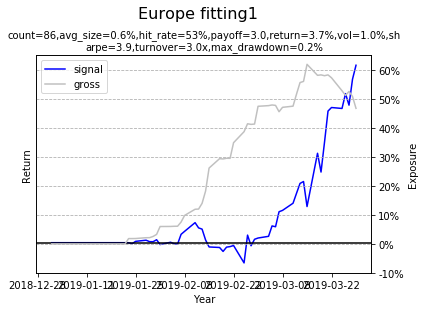

In [148]:
Europe_fit1.plot_account("Europe fitting1")

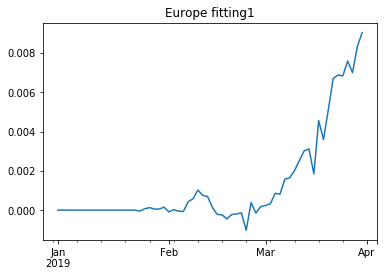

In [149]:
Europe_fit1.portfolio_account[1].plot(title="Europe fitting1")

In [173]:
Europe_fit2=signal(fundamental_df=Europe,
                   price_df=Europe_price,
                   EAR_period=2,
                   long_criteria=((2,1000),(0.02,1000),None,None),
                   short_criteria=((-1000,-1),(-1000,-0.03),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,31))

In [174]:
_long_Europe,_short_Europe,_alpha_Europe,_portfolio_Europe=Europe_fit2.signal_account(stop=(8,8),
                                                           gross=(10,5),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=22)

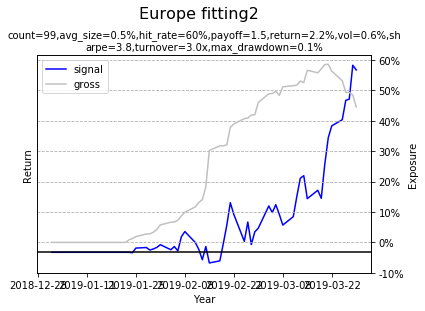

In [175]:
Europe_fit2.plot_account("Europe fitting2")

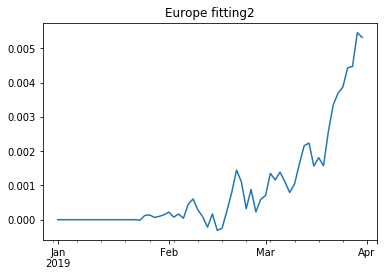

In [176]:
Europe_fit2.portfolio_account[1].plot(title="Europe fitting2")

In [177]:
Europe_fit3=signal(fundamental_df=Europe,
                   price_df=Europe_price,
                   EAR_period=2,
                   long_criteria=((2,1000),(0.04,1000),None,None),
                   short_criteria=((-1000,-2),(-1000,-0.02),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,31))

In [178]:
_long_Europe,_short_Europe,_alpha_Europe,_portfolio_Europe=Europe_fit3.signal_account(stop=(8,8),
                                                           gross=(10,5),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=22)

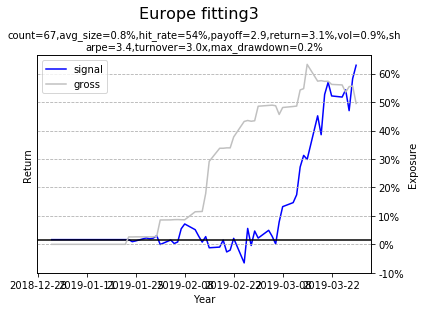

In [181]:
Europe_fit3.plot_account("Europe fitting3")

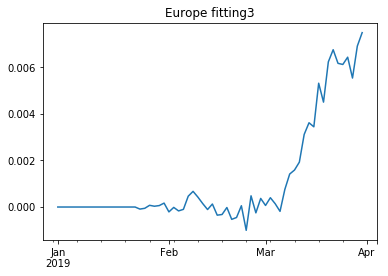

In [182]:
Europe_fit3.portfolio_account[1].plot(title="Europe fitting3")

In [198]:
Asia_fit1=signal(fundamental_df=Asia,
                   price_df=Asia_price,
                   EAR_period=2,
                   long_criteria=((1,1000),(0.02,1000),None,None),
                   short_criteria=None,
                   holding=20,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,31))

In [216]:
_long_Asia,_short_Asia,_alpha_Asia,_portfolio_Asia=Asia_fit1.signal_account(stop=(8,8),
                                                           gross=(10,None),
                                                           index_df=abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T,
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=17)

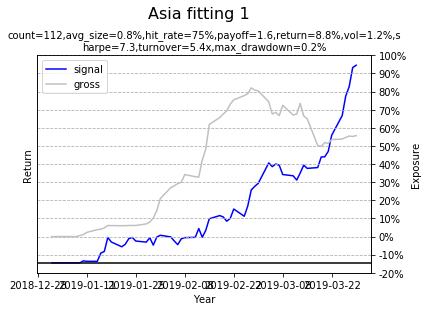

In [206]:
Asia_fit1.plot_account("Asia fitting 1")

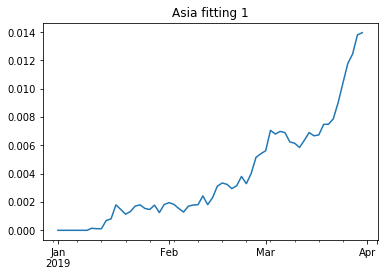

In [217]:
Asia_fit1.portfolio_account[1].plot(title="Asia fitting 1")

In [218]:
Asia_fit2=signal(fundamental_df=Asia,
                   price_df=Asia_price,
                   EAR_period=2,
                   long_criteria=((1,1000),(0.03,1000),None,None),
                   short_criteria=None,
                   holding=20,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,31))

In [219]:
_long_Asia,_short_Asia,_alpha_Asia,_portfolio_Asia=Asia_fit2.signal_account(stop=(8,8),
                                                           gross=(10,None),
                                                           index_df=abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T,
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=17)

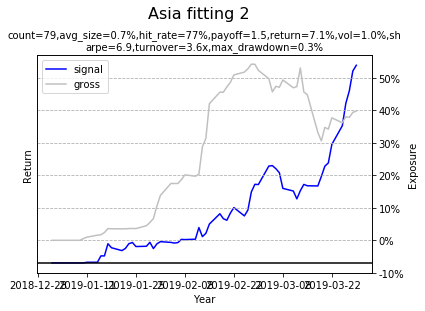

In [220]:
Asia_fit2.plot_account("Asia fitting 2")

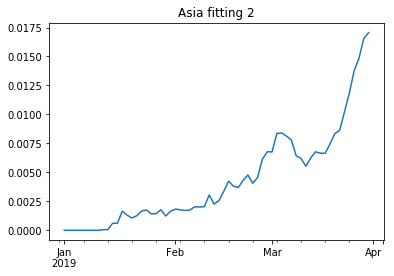

In [221]:
Asia_fit2.portfolio_account[1].plot(title="Asia fitting 2")

In [212]:
Asia_fit3=signal(fundamental_df=Asia,
                   price_df=Asia_price,
                   EAR_period=2,
                   long_criteria=((1,1000),(0.04,1000),None,None),
                   short_criteria=None,
                   holding=20,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,31))

In [222]:
_long_Asia,_short_Asia,_alpha_Asia,_portfolio_Asia=Asia_fit3.signal_account(stop=(8,8),
                                                           gross=(10,None),
                                                           index_df=abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T,
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=17)

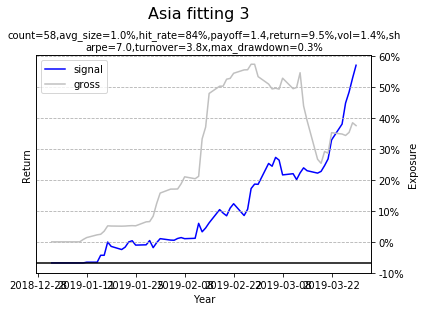

In [223]:
Asia_fit3.plot_account("Asia fitting 3")

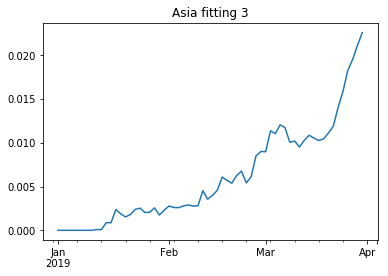

In [224]:
Asia_fit3.portfolio_account[1].plot(title="Asia fitting 3")

In [96]:
US_fit1=signal(fundamental_df=US,
                   price_df=US_price,
                   EAR_period=2,
                   long_criteria=((3,1000),(0.02,1000),None,None),
                   short_criteria=((-1000,-1),(-1000,-0.02),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,31))

In [102]:
_long,_short,_alpha,_portfolio=US_fit1.signal_account(stop=(8,8),
                                                           gross=(15,10),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=15)

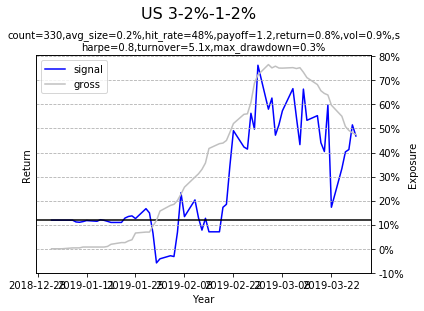

In [103]:
US_fit1.plot_account("US 3-2%-1-2%")

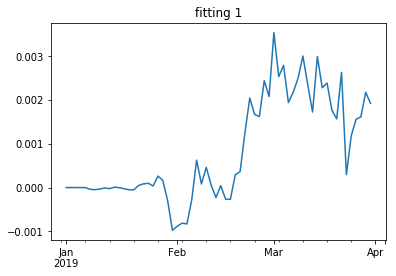

In [127]:
US_fit1.portfolio_account[1].plot(title="fitting 1")

In [105]:
US_fit2=signal(fundamental_df=US,
                   price_df=US_price,
                   EAR_period=2,
                   long_criteria=((4,1000),(0.02,1000),None,None),
                   short_criteria=((-1000,-1),(-1000,-0.02),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,31))

In [106]:
_long,_short,_alpha,_portfolio=US_fit2.signal_account(stop=(8,8),
                                                           gross=(15,10),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=15)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


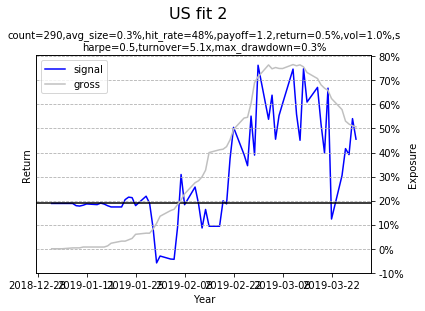

In [108]:
US_fit2.plot_account("US fit 2")

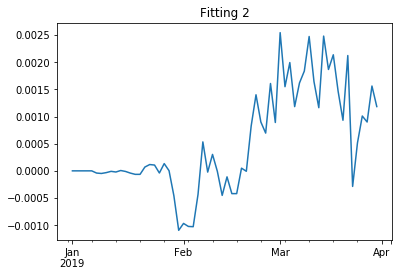

In [128]:
US_fit2.portfolio_account[1].plot(title="Fitting 2")

In [109]:
US_fit3=signal(fundamental_df=US,
                   price_df=US_price,
                   EAR_period=2,
                   long_criteria=((4,1000),(0.03,1000),None,None),
                   short_criteria=((-1000,-1),(-1000,-0.02),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,31))

In [110]:
_long,_short,_alpha,_portfolio=US_fit3.signal_account(stop=(8,8),
                                                           gross=(15,10),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=15)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


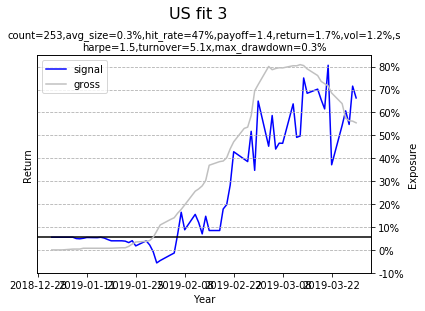

In [114]:
US_fit3.plot_account("US fit 3")

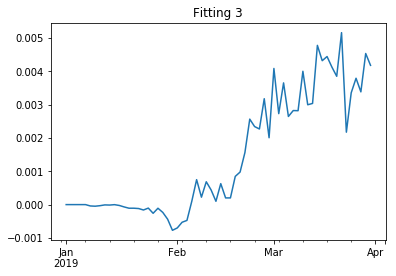

In [129]:
US_fit3.portfolio_account[1].plot(title="Fitting 3")

In [38]:
combine=combine_signal([_portfolio_Asia],[50])

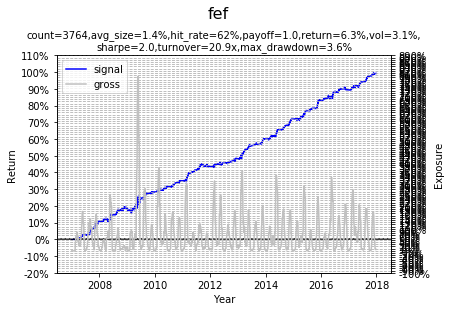

In [39]:
plot_signal("fef",[6,4],combine)

# 7 - Drawdown analysis

In [69]:
def drawdown_days(acct_curve,timestamp):
    dd=acct_curve-acct_curve.cummax()
    previous_high=acct_curve.loc[:timestamp].max()
    high_timestamp=acct_curve[acct_curve==previous_high].index[0]
    days=acct_curve.index.tolist().index(timestamp)-acct_curve.index.tolist().index(high_timestamp)
    return (high_timestamp,days)

In [70]:
def drawdown_df(portfolio_cache):
    drawdown=portfolio_cache[-1].iloc[:,-1].to_frame()
    drawdown.columns=["Index"]
    drawdown["Index vol"]=drawdown["Index"].rolling(30).std()
    drawdown["Portfolio"]=portfolio_cache[1].diff(1)
    drawdown["Account"]=portfolio_cache[1].copy()
    drawdown["Drawdown"]= drawdown["Account"]- drawdown["Account"].cummax()
    drawdown["Drawdown days"]= drawdown.apply(lambda x: drawdown_days(drawdown["Account"],x.name)[1],axis=1)
    drawdown["Drawdown start"]= drawdown.apply(lambda x: drawdown_days(drawdown["Account"],x.name)[0],axis=1)
    drawdown["Gross"]=np.abs(portfolio_cache[2]).sum(axis=1)
    return drawdown
    

In [71]:
def portfolio_drawdown_df(portfolio_cache,stop,multiple):
    portfolio_cache_list=list(portfolio_cache)
    orig_size=portfolio_cache_list[2]
    orig_account=portfolio_cache_list[1]
    dd=orig_account-orig_account.cummax()
    stop_evaluate=dd[dd.shift(1)<stop]
    adj_size=orig_size.apply(lambda x: x*multiple if x.name in stop_evaluate.index else x,axis=1)
    
    new_portfolio_cache=portfolio_cache_list.copy()
    new_portfolio_cache[2]=adj_size
    new_portfolio_cache[0]=adj_size.shift(1)*new_portfolio_cache[-1]
    new_portfolio_cache[1]=new_portfolio_cache[0].sum(axis=1).cumsum()
    return tuple(new_portfolio_cache)
    

# 8 - Sizing for the live trading

In [123]:
US_live=signal(fundamental_df=US,
                   price_df=US_price,
                   EAR_period=2,
                   long_criteria=((4,1000),(0.03,1000),None,None),
                   short_criteria=((-1000,-2),(-1000,-0.03),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,31))

In [124]:
_long_US_live,_short_US_live,_alpha_US_live,_portfolio_US_live=US_live.signal_account(stop=(8,8),
                                                           gross=(30,15),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=18)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


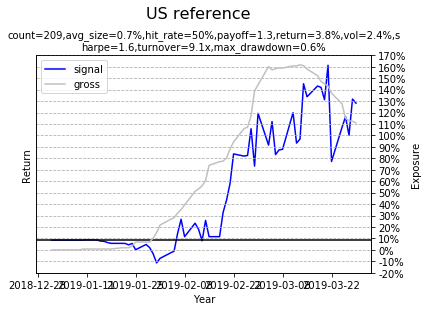

In [125]:
US_live.plot_account("US reference")

In [126]:
'''
US reference sizing and volatility
'''
print("US long size is "+str(_long_US_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("US long volatility is "+str(US.loc[_long_US_live[-1].index]["30d_vol"].mean()))
print("US long number is "+str(_long_US_live[2].count(axis=1).mean()))
print("US short size is "+str(_short_US_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("US short volatility is "+str(US.loc[_short_US_live[-1].index]["30d_vol"].mean()))
print("US short number is "+str(_short_US_live[2].count(axis=1).mean()))

US long size is 0.007163045772767954
US long volatility is 0.019789637825912264
US long number is 48.46875
US short size is -0.004882442888971622
US short volatility is 0.0170710331789369
US short number is 35.265625


In [169]:
Europe_live1=signal(fundamental_df=Europe,
                   price_df=Europe_price,
                   EAR_period=2,
                   long_criteria=((2,1000),(0.04,1000),None,None),
                   short_criteria=((-1000,-2),(-1000,-0.02),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,31))

In [170]:
_long_Europe_live,_short_Europe_live,_alpha_Europe_live,_portfolio_Europe_live=Europe_live1.signal_account(stop=(8,8),
                                                           gross=(30,15),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=22)

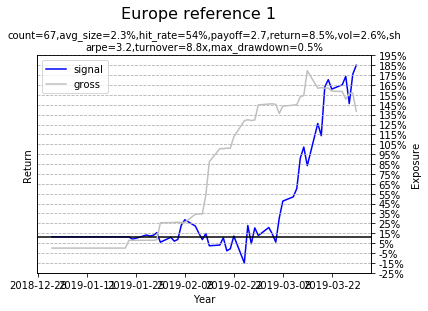

In [171]:
Europe_live1.plot_account("Europe reference 1")

In [172]:
'''
Europe reference sizing and volatility
'''
print("Europe long size is "+str(_long_Europe_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("Europe long volatility is "+str(Europe.loc[_long_Europe_live[-1].index]["30d_vol"].mean()))
print("Europe long number is "+str(_long_Europe_live[2].count(axis=1).mean()))
print("Europe short size is "+str(_short_Europe_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("Europe short volatility is "+str(Europe.loc[_short_Europe_live[-1].index]["30d_vol"].mean()))
print("Europe short number is "+str(_short_Europe_live[2].count(axis=1).mean()))

Europe long size is 0.054903106738047144
Europe long volatility is 0.01877867359297485
Europe long number is 6.3125
Europe short size is -0.008466926353569286
Europe short volatility is 0.015262946535021417
Europe short number is 19.03125


In [194]:
Asia_live=signal(fundamental_df=Asia,
                   price_df=Asia_price,
                   EAR_period=2,
                   long_criteria=((1,1000),(0.04,1000),None,None),
                   short_criteria=None,
                   holding=20,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,31))

In [195]:
_long_Asia_live,_short_Asia_live,_alpha_Asia_live,_portfolio_Asia_live=Asia_live.signal_account(stop=(8,None),
                                                           gross=(30,None),
                                                           index_df=abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T,
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=17)

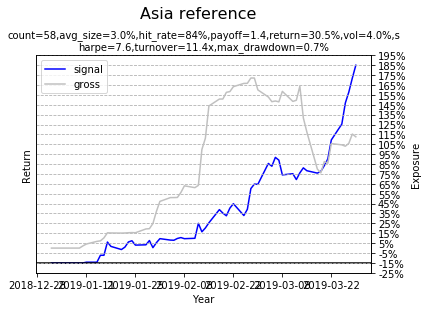

In [196]:
Asia_live.plot_account("Asia reference")

In [197]:
'''
Europe reference sizing and volatility
'''
print("Asia long size is "+str(_long_Asia_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("Asia long volatility is "+str(Asia.loc[_long_Asia_live[-1].index]["30d_vol"].mean()))
print("Asia long number is "+str(_long_Asia_live[2].count(axis=1).mean()))




Asia long size is 0.02501626817061587
Asia long volatility is 0.024480797676987933
Asia long number is 15.1875
